In [2]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
seed_urls = [
    'https://www.goal.com',
    'https://www.skysports.com/football',
    'https://www.espn.com/football',
    'https://www.bbc.com/sport/football',
    'https://www.theguardian.com/football',
    'https://www.sportingnews.com/soccer',
    'https://www.cbs.com/sports/soccer',
    'https://www.bleacherreport.com/soccer',
    'https://www.independent.co.uk/sport/football',
    'https://www.mirror.co.uk/sport/football'
]


In [4]:
def crawl_roots(seed_urls, crawl_limit=100, visit_limit=50):
    crawled_pages = set()
    links = {}

    for url in seed_urls:
        if len(crawled_pages) >= crawl_limit:
            break
        try:
            page_content = requests.get(url).text
            soup = BeautifulSoup(page_content, 'html.parser')
            crawled_pages.add(url)
            links[url] = set()

            for link in soup.find_all('a', href=True):
                link_url = link['href']
                if link_url.startswith("http"):
                    links[url].add(link_url)
                    if len(crawled_pages) < visit_limit:
                        crawled_pages.add(link_url)
        except requests.exceptions.RequestException as e:
            print(f"Error crawling {url}: {e}")

    return links

web_connection = crawl_roots(seed_urls, crawl_limit=100, visit_limit=50)


In [5]:
inverted_index = {}
for page, links in web_connection.items():

    inverted_index[page] = [page.split('/')[-1]]


In [6]:
web_graph = nx.DiGraph()

for page, links in web_connection.items():
    for link in links:
        web_graph.add_edge(page, link)


In [7]:
pagerank_scores = nx.pagerank(web_graph)


In [8]:
hits_scores = nx.hits(web_graph)
hub_scores, authority_scores = hits_scores


In [9]:
def search(query, inverted_index, pagerank_scores=None, hits_scores=None):
    relevant_pages = inverted_index.get(query, [])

    if pagerank_scores:
        relevant_pages.sort(key=lambda page: pagerank_scores.get(page, 0), reverse=True)
    elif hits_scores:
        relevant_pages.sort(key=lambda page: hits_scores[1].get(page, 0), reverse=True)

    return relevant_pages

query = "football"
result_pages = search(query, inverted_index, pagerank_scores=pagerank_scores)

print("Top Pages for the Query: 'football'")
print(result_pages)


Top Pages for the Query: 'football'
[]


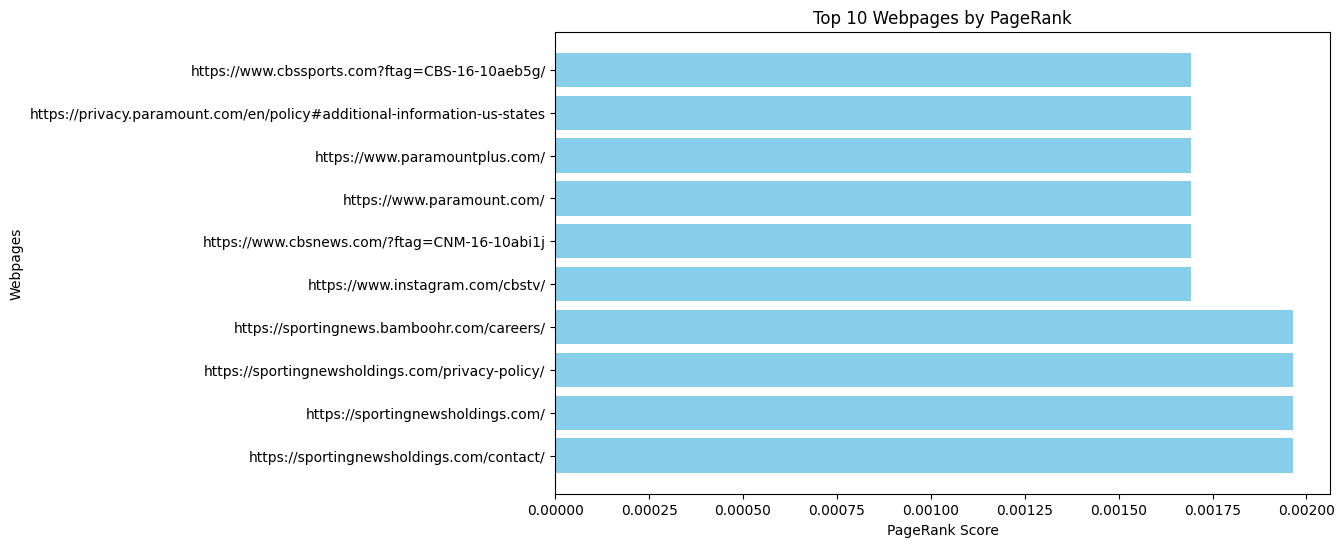

In [10]:
top_pages_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_pages_pagerank_names = [x[0] for x in top_pages_pagerank]
top_page_scores = [x[1] for x in top_pages_pagerank]

plt.figure(figsize=(10, 6))
plt.barh(top_pages_pagerank_names, top_page_scores, color='skyblue')
plt.xlabel('PageRank Score')
plt.ylabel('Webpages')
plt.title('Top 10 Webpages by PageRank')
plt.show()
